In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectFromModel,SequentialFeatureSelector

from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score,confusion_matrix,roc_auc_score

import warnings
warnings.simplefilter('ignore')

In [2]:
def model_basic(x_train, y_train, x_test, y_test):
    models = [
        LogisticRegression(),
        LinearDiscriminantAnalysis(),
        GaussianNB(),
        RandomForestClassifier(),
        XGBClassifier(),
        
    ]

    rdict = {'model': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'auc_score': []}

    for clf in models:
        clf = clf.fit(x_train, y_train)
        pred = clf.predict(x_test)
        pred_prob_rf = clf.predict_proba(x_test)[:, 1].reshape(-1, 1)
        auc_score = roc_auc_score(y_test, pred_prob_rf)
        results = (
            round(accuracy_score(y_test, pred), 4),
            round(precision_score(y_test, pred), 4),
            round(recall_score(y_test, pred), 4),
            round(f1_score(y_test, pred), 4),
            round(auc_score, 4)
        )

        rdict['model'].append(clf)
        rdict['accuracy'].append(results[0])
        rdict['precision'].append(results[1])
        rdict['recall'].append(results[2])
        rdict['f1_score'].append(results[3])
        rdict['auc_score'].append(results[4])

        confusion = confusion_matrix(y_test, pred)
        print(confusion)

    rdf = pd.DataFrame(data=rdict)
    return rdf

In [3]:
train = pd.read_csv("./data/통계검증완료/코스닥_standard_train.csv",index_col=0)
test =  pd.read_csv("./data/통계검증완료/코스닥_standard_test.csv",index_col=0)

train["거래소코드"] = train["거래소코드"].astype("object")
train["회계년도"] = train["회계년도"].astype("object")

test["거래소코드"] = test["거래소코드"].astype("object")
test["회계년도"] = test["회계년도"].astype("object")

----

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4331 entries, 0 to 4330
Data columns (total 38 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   회사명           4331 non-null   object 
 1   거래소코드         4331 non-null   object 
 2   회계년도          4331 non-null   object 
 3   산업군           4331 non-null   object 
 4   총자본순이익률       4331 non-null   float64
 5   매출액증가율차분      4331 non-null   float64
 6   매출액증가율        4331 non-null   float64
 7   EBIT/총자산      4331 non-null   float64
 8   총자본정상영업이익률    4331 non-null   float64
 9   EBITDA마진율     4331 non-null   float64
 10  당기전기영업손익/매출액  4331 non-null   float64
 11  WW지수          4331 non-null   float64
 12  차입금의존도        4331 non-null   float64
 13  순운전자본비율       4331 non-null   float64
 14  현금흐름 대 매출액    4331 non-null   float64
 15  현금흐름 대 자산     4331 non-null   float64
 16  누적수익성비율       4331 non-null   float64
 17  당기전기매출액       4331 non-null   float64
 18  CND           4331 non-null   flo

In [5]:
col_int = train.select_dtypes("float").columns
col_int

Index(['총자본순이익률', '매출액증가율차분', '매출액증가율', 'EBIT/총자산', '총자본정상영업이익률', 'EBITDA마진율',
       '당기전기영업손익/매출액', 'WW지수', '차입금의존도', '순운전자본비율', '현금흐름 대 매출액', '현금흐름 대 자산',
       '누적수익성비율', '당기전기매출액', 'CND', '당기전기영업손익', '타인자본회전률', '총자본회전률', '금융비용부담률',
       '자본금회전률', 'WWC변수', 'FINDEP', '총자본증가율', 'TMD', '매출액총이익률', 'SA지수',
       '합계_기말인원(명)', '자기자본증가율', '정상영업이익증가율', '대주주지분율', '자기자본순이익률'],
      dtype='object')

---
#target1
---

In [6]:
x_train = train[col_int]
y_train = train[['target_1']]

x_test = test[col_int]
y_test = test[['target_1']]

In [7]:
y_test.value_counts()

target_1
0           2370
1             72
Name: count, dtype: int64

In [8]:
#  선정된 피쳐를 저장하기 위한 데이터프레임 생성 
df_select = pd.DataFrame()
# 생성된 데이터프레임의 인덱스 지정
df_select.index = x_train.columns

---
# lasso - 임베디드기법
---

In [9]:
#  lasso
selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.01)).fit(x_train, y_train)
df_select["lasso_0.01"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.05)).fit(x_train, y_train)
df_select["lasso_0.05"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.1)).fit(x_train, y_train)
df_select["lasso_0.1"] = selector.get_support()


---
# stepwise - 래퍼기법
---

In [10]:
# logit foward
estimator = LogisticRegression(penalty='l1',solver='liblinear',C=0.05)
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select['logit_fwd'] = selector.get_support().tolist()
# logit backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select['logit_bwd'] = selector.get_support().tolist()

In [11]:
# lda foward
estimator = LinearDiscriminantAnalysis(solver='svd')
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select['lda_fwd'] = selector.get_support().tolist()
# lda backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1,)
selector.fit(x_train, y_train)
df_select['lda_bwd'] = selector.get_support().tolist()

---
## 비모수적 방법
---

In [12]:
# # RandomForest_foward
# estimator = RandomForestClassifier()
# selector = SequentialFeatureSelector(estimator,direction='forward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select['RFC_fwd'] = selector.get_support().tolist()
# # RandomForest _ backward
# selector = SequentialFeatureSelector(estimator,direction='backward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select['RFC_bwd'] = selector.get_support().tolist()

---
## 최종 select
---

In [13]:
for col in df_select.columns.to_list():
    df_select[col] = df_select[col].apply(lambda x : 1 if x==True else 0)
df_select['total'] = df_select.sum(axis=1)
df_select[df_select['total']>=5].index

Index(['총자본순이익률', 'WW지수', '현금흐름 대 매출액', '누적수익성비율', 'CND', 'TMD', '자기자본순이익률'], dtype='object')

In [14]:
df_select[df_select['total']>=5]

,lasso_0.01,lasso_0.05,lasso_0.1,logit_fwd,logit_bwd,lda_fwd,lda_bwd,total
총자본순이익률,1,1,1,0,0,1,1,5
WW지수,0,1,1,0,1,1,1,5
현금흐름 대 매출액,1,1,1,0,1,0,1,5
누적수익성비율,1,1,1,1,1,0,0,5
CND,1,1,1,1,1,0,1,6
TMD,1,1,1,1,1,1,1,7
자기자본순이익률,0,0,1,1,1,1,1,5


In [15]:
최종_col =df_select[df_select['total']>=5].index.to_list()

# temp = ['EBIT/총자산', 'TMD', 'EBITDA마진율', '누적수익성비율', 'abs(영업현금흐름-당기순이익)/매출액', '순운전자본비율','당기전기영업손익']
x_train_1 = x_train[최종_col]
x_test_1 = x_test[최종_col]

<Axes: title={'center': 'Correlation of Features'}>

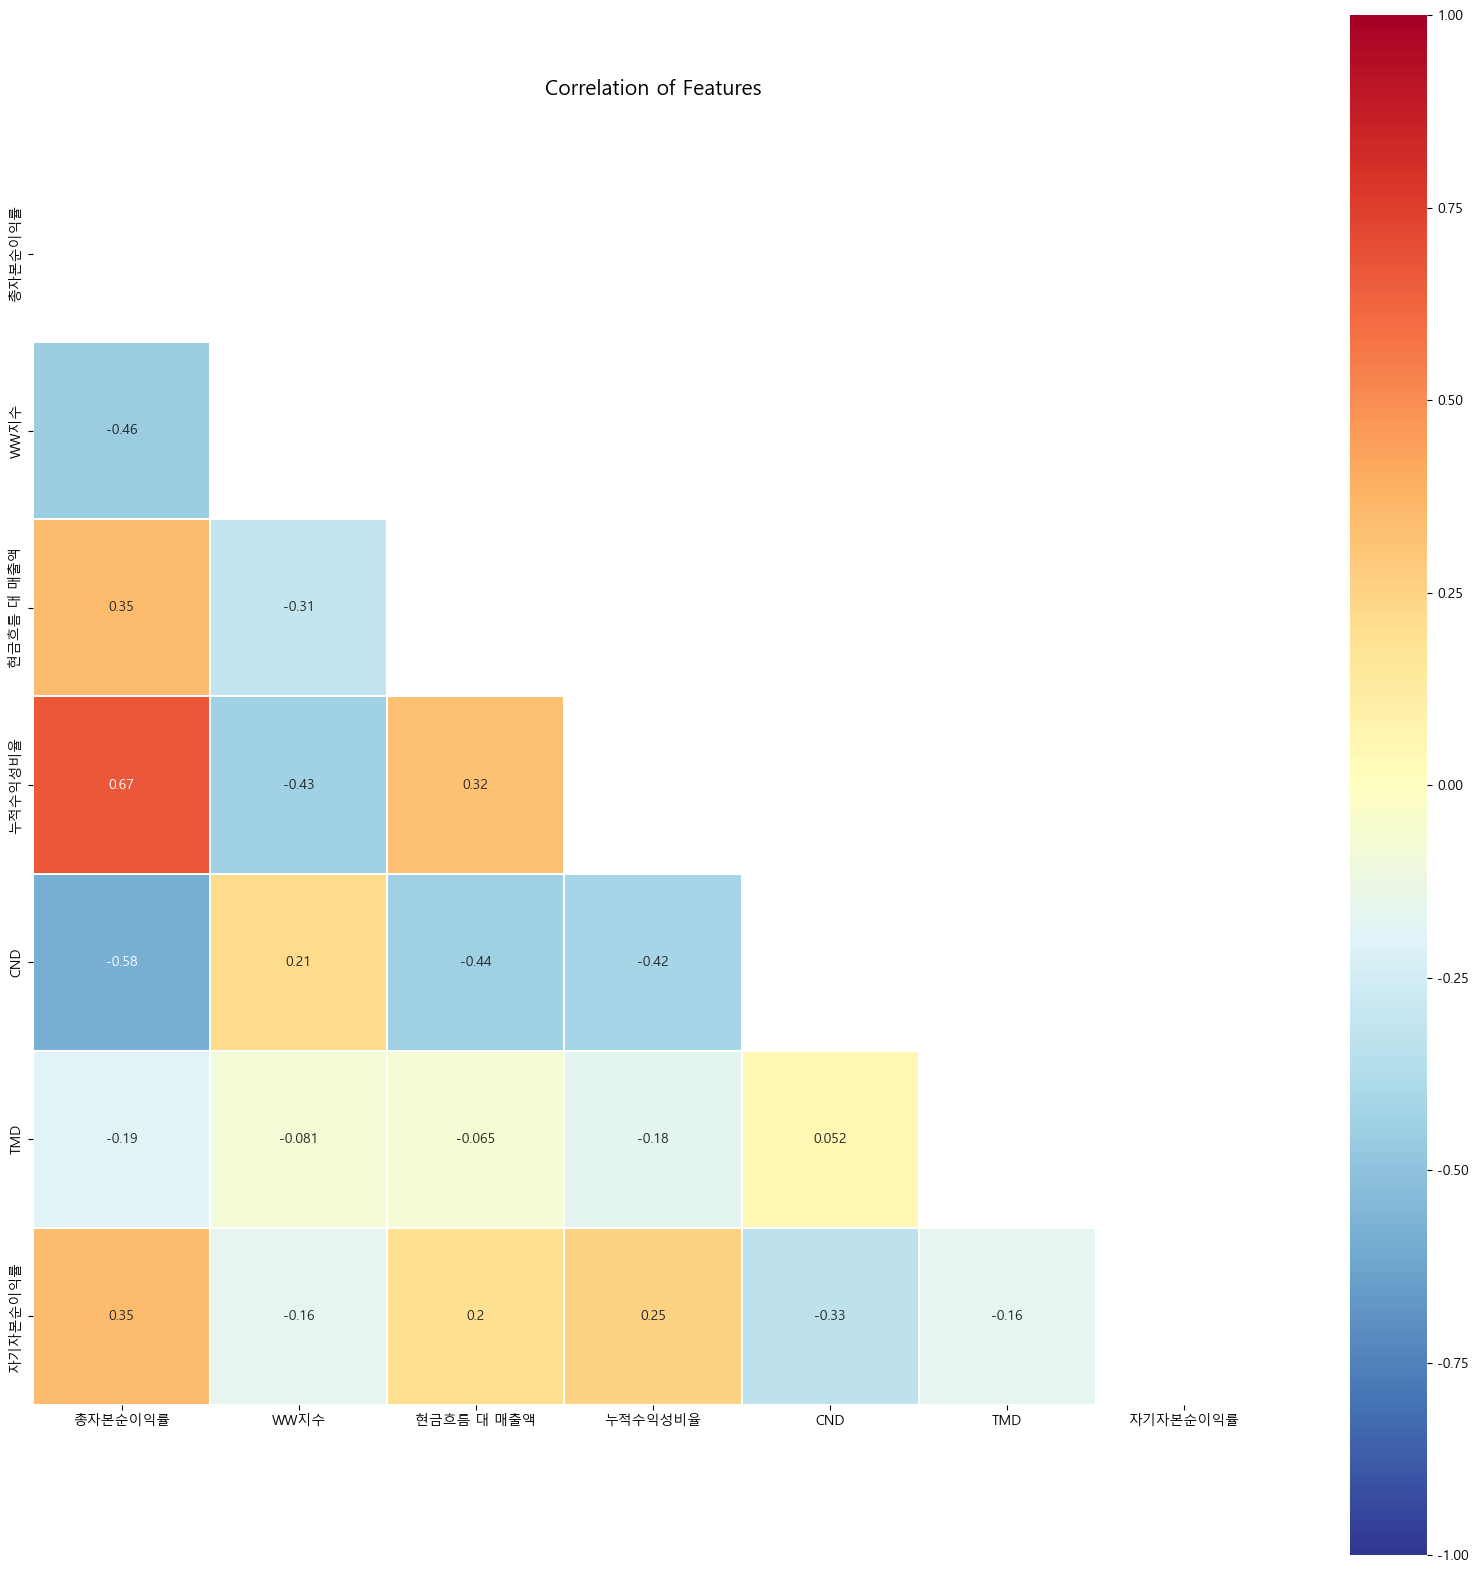

In [16]:
colormap = plt.cm.hot

corr = x_train_1.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(20, 20))
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family="Malgun Gothic")
plt.title("Correlation of Features", y=1.05, size=15)
sns.heatmap(corr,  linewidths=0.1, vmax=1.0, vmin=-1.0, square=True,mask=mask,
            cmap='RdYlBu_r', linecolor="white", annot=True, annot_kws={'size': 10})

In [17]:
model_basic(x_train_1,y_train,x_train_1,y_train)

[[4157    9]
 [  69   96]]
[[4157    9]
 [  80   85]]
[[4054  112]
 [  46  119]]
[[4166    0]
 [   0  165]]
[[4166    0]
 [   0  165]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9820,0.9143,0.5818,0.7111,0.9554
1,LinearDiscriminantAnalysis(),0.9795,0.9043,0.5152,0.6564,0.9528
2,GaussianNB(),0.9635,0.5152,0.7212,0.6010,0.9497
3,"(DecisionTreeClassifier(max_features='sqrt', r...",1.0000,1.0000,1.0000,1.0000,1.0000
4,"XGBClassifier(base_score=None, booster=None, c...",1.0000,1.0000,1.0000,1.0000,1.0000


In [18]:
model_basic(x_train_1,y_train,x_test_1,y_test)

[[2360   10]
 [  25   47]]
[[2358   12]
 [  28   44]]
[[2292   78]
 [  12   60]]
[[2360   10]
 [  23   49]]
[[2359   11]
 [  24   48]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9857,0.8246,0.6528,0.7287,0.9761
1,LinearDiscriminantAnalysis(),0.9836,0.7857,0.6111,0.6875,0.9757
2,GaussianNB(),0.9631,0.4348,0.8333,0.5714,0.9727
3,"(DecisionTreeClassifier(max_features='sqrt', r...",0.9865,0.8305,0.6806,0.7481,0.9702
4,"XGBClassifier(base_score=None, booster=None, c...",0.9857,0.8136,0.6667,0.7328,0.9733


-----
# target2

In [19]:
x_train = train[col_int]
y_train = train[['target_2']]

x_test = test[col_int]
y_test = test[['target_2']]

#  선정된 피쳐를 저장하기 위한 데이터프레임 생성 
df_select_2 = pd.DataFrame()
# 생성된 데이터프레임의 인덱스 지정
df_select_2.index = x_train.columns

In [20]:
#  lasso
selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.01)).fit(x_train, y_train)
df_select_2["lasso_0.01"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.05)).fit(x_train, y_train)
df_select_2["lasso_0.05"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.1)).fit(x_train, y_train)
df_select_2["lasso_0.1"] = selector.get_support()

# logit foward
estimator = LogisticRegression(penalty='l1',solver='liblinear',C=0.05)
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_2['logit_fwd'] = selector.get_support().tolist()
# logit backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_2['logit_bwd'] = selector.get_support().tolist()


# lda foward
estimator = LinearDiscriminantAnalysis(solver='svd')
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_2['lda_fwd'] = selector.get_support().tolist()
# lda backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1,)
selector.fit(x_train, y_train)
df_select_2['lda_bwd'] = selector.get_support().tolist()

# # RandomForest_foward
# estimator = RandomForestClassifier()
# selector = SequentialFeatureSelector(estimator,direction='forward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select_2['RFC_fwd'] = selector.get_support().tolist()
# # RandomForest _ backward
# selector = SequentialFeatureSelector(estimator,direction='backward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select_2['RFC_bwd'] = selector.get_support().tolist()

In [21]:
for col in df_select_2.columns.to_list():
    df_select_2[col] = df_select_2[col].apply(lambda x : 1 if x==True else 0)
df_select_2['total'] = df_select_2.sum(axis=1)
df_select_2[df_select_2['total']>=5].index


Index(['총자본순이익률', 'WW지수', '현금흐름 대 매출액', '누적수익성비율', 'CND', 'TMD', '자기자본순이익률'], dtype='object')

In [22]:
df_select_2[df_select_2['total']>=5]

,lasso_0.01,lasso_0.05,lasso_0.1,logit_fwd,logit_bwd,lda_fwd,lda_bwd,total
총자본순이익률,1,1,1,0,0,1,1,5
WW지수,0,1,1,0,1,1,1,5
현금흐름 대 매출액,1,1,1,0,1,0,1,5
누적수익성비율,1,1,1,1,1,0,0,5
CND,1,1,1,1,1,0,1,6
TMD,1,1,1,1,1,1,1,7
자기자본순이익률,0,0,1,1,1,1,1,5


In [23]:
최종_col =df_select_2[df_select_2['total']>=5].index.to_list()

x_train_2 = x_train[최종_col]
x_test_2 = x_test[최종_col]

<Axes: title={'center': 'Correlation of Features'}>

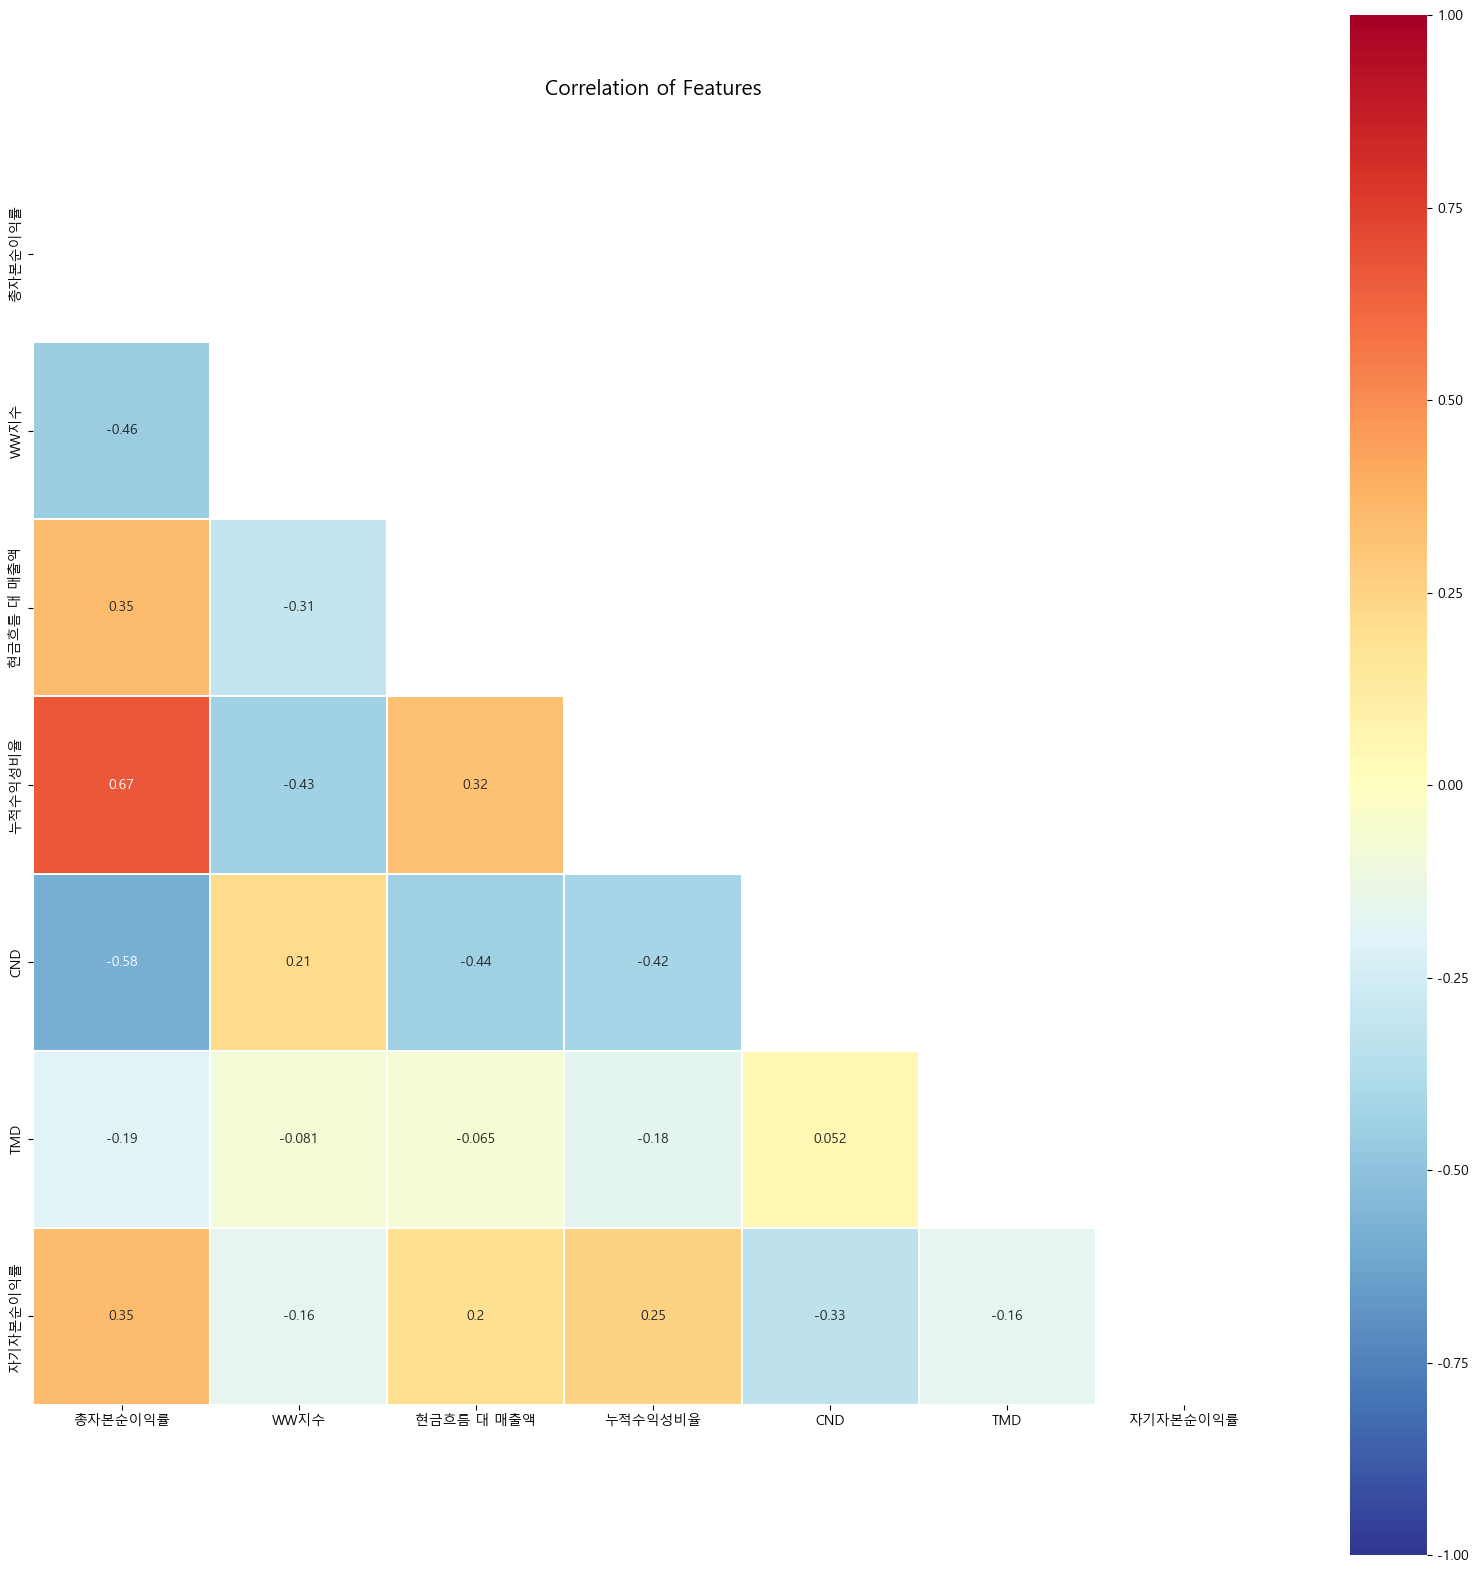

In [24]:
colormap = plt.cm.hot

corr = x_train_2.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(20, 20))
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family="Malgun Gothic")
plt.title("Correlation of Features", y=1.05, size=15)
sns.heatmap(corr,  linewidths=0.1, vmax=1.0, vmin=-1.0, square=True,mask=mask,
            cmap='RdYlBu_r', linecolor="white", annot=True, annot_kws={'size': 10})

In [25]:
model_basic(x_train_2,y_train,x_train_2,y_train)

[[4157    9]
 [  69   96]]
[[4157    9]
 [  80   85]]
[[4054  112]
 [  46  119]]
[[4166    0]
 [   0  165]]
[[4166    0]
 [   0  165]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9820,0.9143,0.5818,0.7111,0.9554
1,LinearDiscriminantAnalysis(),0.9795,0.9043,0.5152,0.6564,0.9528
2,GaussianNB(),0.9635,0.5152,0.7212,0.6010,0.9497
3,"(DecisionTreeClassifier(max_features='sqrt', r...",1.0000,1.0000,1.0000,1.0000,1.0000
4,"XGBClassifier(base_score=None, booster=None, c...",1.0000,1.0000,1.0000,1.0000,1.0000


In [26]:
model_basic(x_train_2,y_train,x_test_2,y_test)

[[2360   10]
 [  25   47]]
[[2358   12]
 [  28   44]]
[[2292   78]
 [  12   60]]
[[2359   11]
 [  24   48]]
[[2359   11]
 [  24   48]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9857,0.8246,0.6528,0.7287,0.9761
1,LinearDiscriminantAnalysis(),0.9836,0.7857,0.6111,0.6875,0.9757
2,GaussianNB(),0.9631,0.4348,0.8333,0.5714,0.9727
3,"(DecisionTreeClassifier(max_features='sqrt', r...",0.9857,0.8136,0.6667,0.7328,0.9688
4,"XGBClassifier(base_score=None, booster=None, c...",0.9857,0.8136,0.6667,0.7328,0.9733


----
# target3

In [27]:
x_train = train[col_int]
y_train = train[['target_3']]

x_test = test[col_int]
y_test = test[['target_3']]

c= train['target_3'].value_counts()
#  선정된 피쳐를 저장하기 위한 데이터프레임 생성 
df_select_3 = pd.DataFrame()
# 생성된 데이터프레임의 인덱스 지정
df_select_3.index = x_train.columns

In [28]:
#  lasso
selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.01)).fit(x_train, y_train)
df_select_3["lasso_0.01"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.05)).fit(x_train, y_train)
df_select_3["lasso_0.05"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.1)).fit(x_train, y_train)
df_select_3["lasso_0.1"] = selector.get_support()

# logit foward
estimator = LogisticRegression(penalty='l1',solver='liblinear',C=0.05)
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_3['logit_fwd'] = selector.get_support().tolist()
# logit backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_3['logit_bwd'] = selector.get_support().tolist()


# lda foward
estimator = LinearDiscriminantAnalysis(solver='svd')
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_3['lda_fwd'] = selector.get_support().tolist()
# lda backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1,)
selector.fit(x_train, y_train)
df_select_3['lda_bwd'] = selector.get_support().tolist()

# # RandomForest_foward
# estimator = RandomForestClassifier()
# selector = SequentialFeatureSelector(estimator,direction='forward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select_3['RFC_fwd'] = selector.get_support().tolist()
# # RandomForest _ backward
# selector = SequentialFeatureSelector(estimator,direction='backward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select_3['RFC_bwd'] = selector.get_support().tolist()

In [29]:
for col in df_select_3.columns.to_list():
    df_select_3[col] = df_select_3[col].apply(lambda x : 1 if x==True else 0)
df_select_3['total'] = df_select_3.sum(axis=1)
df_select_3[df_select_3['total']>=5].index

Index(['총자본순이익률', 'WW지수', '현금흐름 대 매출액', '누적수익성비율', 'CND', 'TMD', '자기자본순이익률'], dtype='object')

In [30]:
df_select_3[(df_select_3['total']>=5)]

,lasso_0.01,lasso_0.05,lasso_0.1,logit_fwd,logit_bwd,lda_fwd,lda_bwd,total
총자본순이익률,1,1,1,0,0,1,1,5
WW지수,0,1,1,0,1,1,1,5
현금흐름 대 매출액,1,1,1,0,1,0,1,5
누적수익성비율,1,1,1,1,1,0,0,5
CND,1,1,1,1,1,0,1,6
TMD,1,1,1,1,1,1,1,7
자기자본순이익률,0,0,1,1,1,1,1,5


In [31]:
최종_col =df_select_3[df_select_3['total']>=5].index.to_list()

x_train_3 = x_train[최종_col]
x_test_3 = x_test[최종_col]

<Axes: title={'center': 'Correlation of Features'}>

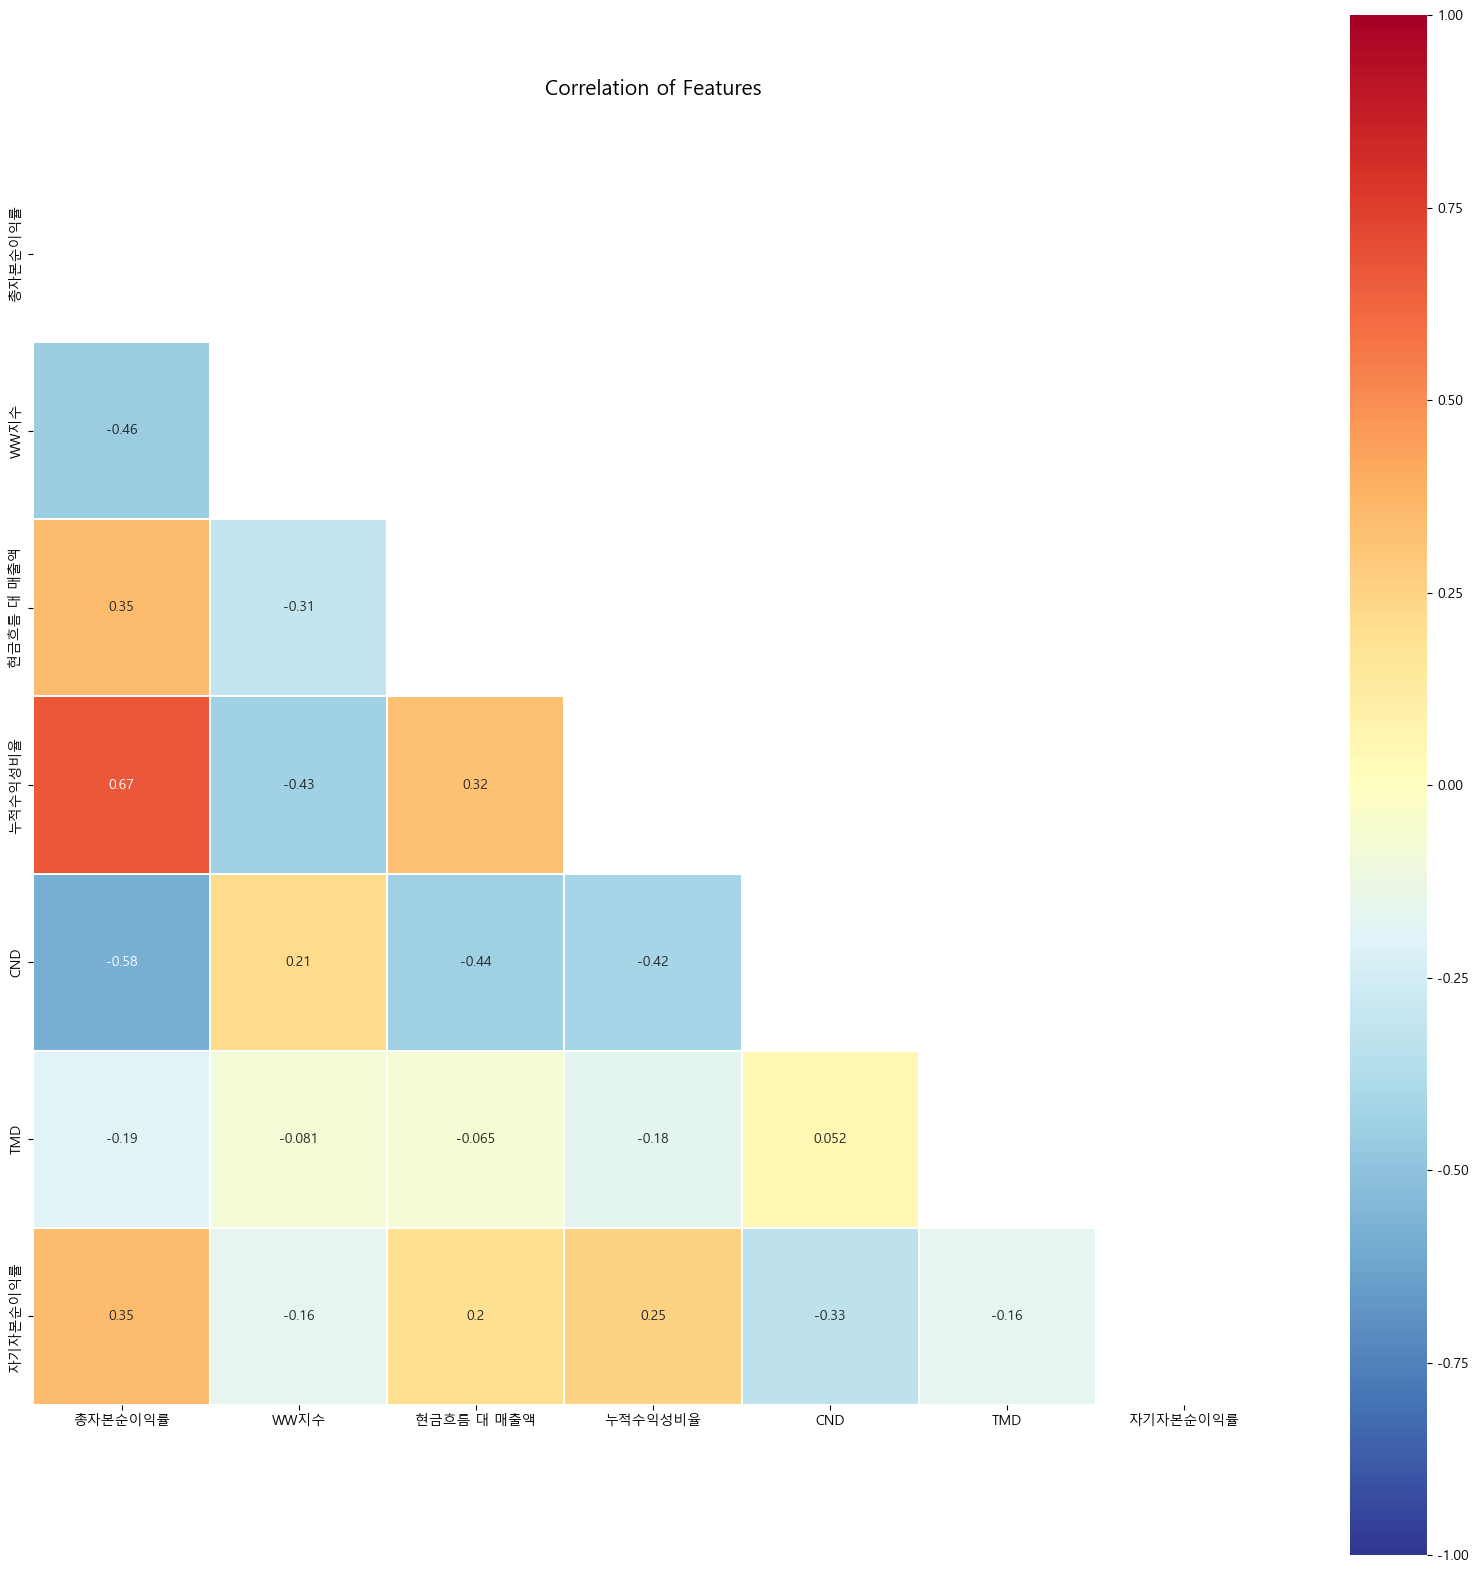

In [32]:
colormap = plt.cm.hot

corr = x_train_3.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(20, 20))
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family="Malgun Gothic")
plt.title("Correlation of Features", y=1.05, size=15)
sns.heatmap(corr,  linewidths=0.1, vmax=1.0, vmin=-1.0, square=True,mask=mask,
            cmap='RdYlBu_r', linecolor="white", annot=True, annot_kws={'size': 10})

In [33]:
model_basic(x_train_3,y_train,x_train_3,y_train)

[[4157    9]
 [  69   96]]
[[4157    9]
 [  80   85]]
[[4054  112]
 [  46  119]]
[[4166    0]
 [   1  164]]
[[4166    0]
 [   0  165]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9820,0.9143,0.5818,0.7111,0.9554
1,LinearDiscriminantAnalysis(),0.9795,0.9043,0.5152,0.6564,0.9528
2,GaussianNB(),0.9635,0.5152,0.7212,0.6010,0.9497
3,"(DecisionTreeClassifier(max_features='sqrt', r...",0.9998,1.0000,0.9939,0.9970,1.0000
4,"XGBClassifier(base_score=None, booster=None, c...",1.0000,1.0000,1.0000,1.0000,1.0000


In [34]:
model_basic(x_train_3,y_train,x_test_3,y_test)

[[2360   10]
 [  25   47]]
[[2358   12]
 [  28   44]]
[[2292   78]
 [  12   60]]
[[2362    8]
 [  24   48]]
[[2359   11]
 [  24   48]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9857,0.8246,0.6528,0.7287,0.9761
1,LinearDiscriminantAnalysis(),0.9836,0.7857,0.6111,0.6875,0.9757
2,GaussianNB(),0.9631,0.4348,0.8333,0.5714,0.9727
3,"(DecisionTreeClassifier(max_features='sqrt', r...",0.9869,0.8571,0.6667,0.7500,0.9571
4,"XGBClassifier(base_score=None, booster=None, c...",0.9857,0.8136,0.6667,0.7328,0.9733


-----------------------


In [35]:
print("타겟 1 컬럼 : ",x_train_1.columns)
print("타겟 2 컬럼 : ",x_train_2.columns)
print("타겟 3 컬럼 : ",x_train_3.columns)

타겟 1 컬럼 :  Index(['총자본순이익률', 'WW지수', '현금흐름 대 매출액', '누적수익성비율', 'CND', 'TMD', '자기자본순이익률'], dtype='object')
타겟 2 컬럼 :  Index(['총자본순이익률', 'WW지수', '현금흐름 대 매출액', '누적수익성비율', 'CND', 'TMD', '자기자본순이익률'], dtype='object')
타겟 3 컬럼 :  Index(['총자본순이익률', 'WW지수', '현금흐름 대 매출액', '누적수익성비율', 'CND', 'TMD', '자기자본순이익률'], dtype='object')
